In [14]:
import os
import pandas as pd
import csv
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
from adjustText import adjust_text

In [268]:
# declare CSV variable names
# change to computer file path and add the title 'ModelID' to first column of CRISPRGeneEffect.csv
pd.options.display.max_rows = 99999
pd.options.display.max_columns = 99999
model = '/Users/connormullins/Excel sheets/Model.csv'
osm = '/Users/connormullins/Excel sheets/OmicsSomaticMutations.csv'
effect = '/Users/connormullins/Excel sheets/CRISPRGeneEffect.csv'

In [269]:
# convert CSVs to pandas dataframes
model_df = pd.read_csv(model, header=0, index_col=0)
osm_df = pd.read_csv(osm, header=0)
effect_df = pd.read_csv(effect, header=0, index_col=0)

/var/folders/k9/bz30f50d0bv1pzq8kv4wkg4h0000gn/T/ipykernel_21313/3585096085.py:3: DtypeWarning: Columns (20,48,52,54,55,56,57,59) have mixed types. Specify dtype option on import or set low_memory=False.
  osm_df = pd.read_csv(osm, header=0)


In [371]:
# filter model.csv to only keep indices which contain cancer type declared
cancer = "Non-Small Cell Lung Cancer"
filter_model = model_df[model_df["OncotreePrimaryDisease"] == cancer]
# filter the OmicsSomaticMutations.csv to only include model ids that have declared cancer type
osm_filter = pd.merge(filter_model, osm_df, on=['ModelID'], how='inner')
# filter that dataframe to only include the gene and mutation declared
gene = 'KRAS'
mutation = "p.G12C"
osm_gene_filter = osm_filter[(osm_filter['HugoSymbol'] == gene)]
osm_mutant_filter = osm_gene_filter[(osm_gene_filter['ProteinChange'] == mutation)]

In [372]:
# filter such that another dataframe is created for all modelIDs that have a mutation in another gene
# if there is a gene change in the second protein 'is_gene_change' should = True
cancer_2 = "Non-Small Cell Lung Cancer"
filter_model_2 = model_df[model_df["OncotreePrimaryDisease"] == cancer_2]
comutation_gene = "KRAS"
osm_filter_2 = pd.merge(filter_model_2, osm_df, on=['ModelID'], how='inner')
osm_comutant = osm_filter_2[(osm_filter_2['HugoSymbol'] == comutation_gene)]

is_gene_change = True

if is_gene_change == False:
    pass
else:
    comutation_change = "p.Q61H"
    osm_comutant_filter = osm_comutant[(osm_comutant['ProteinChange'] == comutation_change)]

In [373]:
# compare the two dataframes. The models that have a mutation for both the gene and comutant gene will be in a comutant dataframe.
# the models that only have the gene mutation will be under no_comutation
# if there is a comutation, comutation = True, if not comutation = False
comutation = False

if comutation == True:
    comutant = osm_mutant_filter.merge(osm_comutant, on=['ModelID'], how='inner')
    no_comutant = osm_mutant_filter.merge(osm_comutant, on=['ModelID'], how='left')

else:
    comutant = osm_comutant_filter
    no_comutant = osm_mutant_filter

In [374]:
# merge the left and inner parts to make a new merged dataframe with duplicates of the comutants that can be dropped
no_comutant = pd.concat([no_comutant, comutant])
no_comutant = no_comutant.drop_duplicates(keep =  False)
# filter the dataframes just created to only include the model ids of the ones that match the parameters
comutant_filter = comutant.filter(['ModelID'])
no_comutant_dropped = no_comutant.filter(['ModelID'])

In [376]:
# using CRISPRGeneEffect.csv, filter into two dataframes for mutant and comutant and average the values over the row
comutant_effect = comutant_filter.merge(effect_df, on=['ModelID'], how='inner')
comutant_effect = comutant_effect.set_index('ModelID')

comutant_effect = comutant_effect.drop_duplicates(keep =  False)
no_comutant_effect = no_comutant_dropped.merge(effect_df, on=['ModelID'], how='left')
no_comutant_effect = no_comutant_effect.set_index('ModelID')
no_comutant_effect = no_comutant_effect.drop_duplicates(keep =  False)

In [377]:
# t-test to get p-values
p_val = scipy.stats.ttest_ind(no_comutant_effect, comutant_effect, axis = 0, equal_var = True, nan_policy = 'omit')
pvalue = p_val.pvalue

/var/folders/k9/bz30f50d0bv1pzq8kv4wkg4h0000gn/T/ipykernel_21313/1451107236.py:2: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  p_val = scipy.stats.ttest_ind(no_comutant_effect, comutant_effect, axis = 0, equal_var = True, nan_policy = 'omit')


[0.34352114 0.63170975 0.93760962 ... 0.35065458 0.77835603 0.37314386]


In [378]:
# convert pvalues to be used for yaxis
yaxis = -np.emath.logn(10, pvalue)
yaxis = pd.DataFrame(yaxis)
yaxis.rename(columns = {0 : 'nlogpvalue'}, inplace =True)

In [379]:
# find the mean of the dataframes
comutant_mean = comutant_effect.mean(axis = 0, skipna = True)
comutant_mean = comutant_mean.reset_index(drop = True)
no_comutant_mean = no_comutant_effect.mean(axis = 0, skipna = True)
no_comutant_mean = no_comutant_mean.reset_index(drop = True)

In [380]:
# calculate fold change and log2fold change... this applies missing values to negatives
fold_change =  comutant_mean / no_comutant_mean

xaxis = np.log2(fold_change)
xaxis = pd.DataFrame(xaxis)
xaxis.rename(columns = {0 : 'log2FC'}, inplace= True)

          log2FC
0       1.021008
1      -1.073288
2       0.417317
3      -0.384474
4       0.414913
5      -0.927667
6       0.205911
7       0.804515
8            NaN
9      -0.199620
10           NaN
11           NaN
12      1.566304
13     -0.178316
14     -2.776529
15      0.417686
16           NaN
17      0.058209
18     -1.892938
19     -2.080687
20     -0.391663
21     -0.077410
22     -0.144103
23     -0.642743
24     -0.504179
25      0.591417
26      0.293433
27      0.255384
28      0.531976
29           NaN
30     -0.736992
31           NaN
32           NaN
33           NaN
34           NaN
35      0.235507
36     -0.059790
37           NaN
38           NaN
39           NaN
40           NaN
41     -1.571782
42     -0.589357
43      0.370000
44      0.404671
45     -0.129644
46           NaN
47     -6.152357
48      0.124517
49           NaN
50      0.931794
51      0.234129
52     -0.092574
53      3.949194
54      1.265350
55      0.039623
56     -3.667074
57     -0.5131

/opt/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [381]:
# create dataframe that will be plotted on volcano plot
volcano = pd.concat([xaxis, yaxis], axis =1)
volcano = volcano.set_index(no_comutant_effect.columns)
volcano = volcano.reset_index()
volcano.rename(columns = {'index' : 'symbol'}, inplace =True)
print(volcano)

                         symbol     log2FC    nlogpvalue
0                      A1BG (1)   1.021008  4.640465e-01
1                  A1CF (29974)  -1.073288  1.994824e-01
2                       A2M (2)   0.417317  2.797795e-02
3                A2ML1 (144568)  -0.384474  1.501510e-01
4              A3GALT2 (127550)   0.414913  2.125311e-01
5                A4GALT (53947)  -0.927667  4.481709e-01
6                 A4GNT (51146)   0.205911  5.287222e-02
7                   AAAS (8086)   0.804515  1.660333e-01
8                  AACS (65985)        NaN  5.399086e-01
9                    AADAC (13)  -0.199620  8.352590e-02
10             AADACL2 (344752)        NaN  1.753880e-01
11             AADACL3 (126767)        NaN  2.394965e-01
12             AADACL4 (343066)   1.566304  1.265324e-01
13                AADAT (51166)  -0.178316  5.874196e-02
14                AAGAB (79719)  -2.776529  3.579818e-01
15                 AAK1 (22848)   0.417686  2.855468e-01
16                AAMDC (28971)

([Text(-0.5321633290506931, 1.4955933721100896, 'ACTR2 (10097)'),
  Text(-11.138669533892239, 1.6139012365732919, 'ADGRL4 (64123)'),
  Text(11.840294981833054, 1.2612906241849131, 'ADNP2 (22850)'),
  Text(5.339582399600221, 1.7724221992844509, 'AMPD2 (271)'),
  Text(5.003461228974459, 1.231139656040334, 'ANAPC13 (25847)'),
  Text(-8.734693612991169, 1.241548528244614, 'APBA3 (9546)'),
  Text(-5.6604699597953925, 1.6875847846916296, 'APH1A (51107)'),
  Text(-5.368887674066205, 1.5337925100468772, 'ARPC4 (10093)'),
  Text(12.1100954645308, 1.135213575257592, 'ATF7IP (55729)'),
  Text(-7.226980761784684, 1.0766114104238855, 'ATP6V1G1 (9550)'),
  Text(3.9914050383711306, 1.5806492392121452, 'BAG5 (9529)'),
  Text(6.029011369613762, 1.7048465482176343, 'BAIAP3 (8938)'),
  Text(-0.8124270216606959, 1.428350664281345, 'C16orf92 (146378)'),
  Text(8.098782645072571, 1.1176499780953868, 'CA6 (765)'),
  Text(5.835719604969878, 1.4350669655451715, 'CAMTA1 (23261)'),
  Text(-4.693929889497671, 1.6

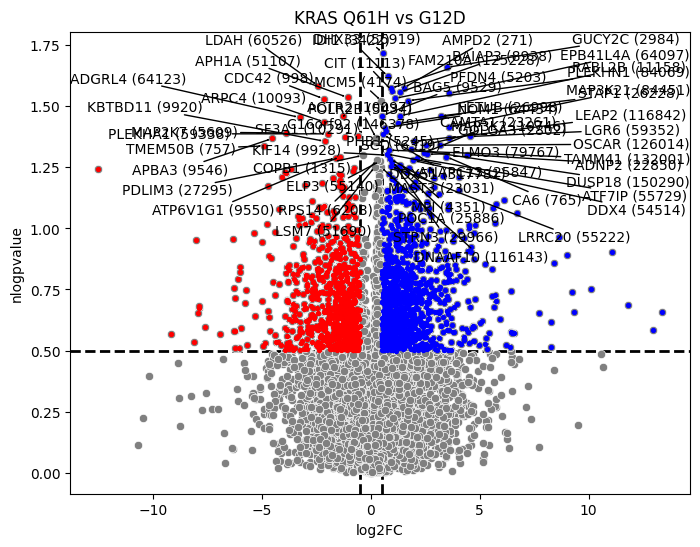

In [384]:
# actually plotting it now

plt.figure(figsize = (8, 6))
point_size = 8
ax = sns.scatterplot(data = volcano, x = 'log2FC', y = 'nlogpvalue', c = 'gray')

ax.axhline(0.5, zorder = 0, c = 'k', lw = 2, ls = '--')
ax.axvline(0.5, zorder = 0, c = 'k', lw = 2, ls = '--')
ax.axvline(-0.5, zorder = 0, c = 'k', lw = 2, ls = '--')




# Conditions for coloring
condition1 = (volcano['nlogpvalue'] > 0.5) & (volcano['log2FC'] > 0.5)
condition2 = (volcano['nlogpvalue'] > 0.5) & (volcano['log2FC'] < -0.5)

# Apply color based on conditions
ax.scatter(volcano.loc[condition1, 'log2FC'], volcano.loc[condition1, 'nlogpvalue'], c='blue', s = point_size)
ax.scatter(volcano.loc[condition2, 'log2FC'], volcano.loc[condition2, 'nlogpvalue'], c='red', s = point_size)

texts = []

for i in range(len(volcano)):
    if volcano.iloc[i].nlogpvalue > 1.25 and (volcano.iloc[i].log2FC > 5 or volcano.iloc[i].log2FC < 5):
        texts.append(plt.text(volcano.iloc[i].log2FC, y = volcano.iloc[i].nlogpvalue, s = volcano.iloc[i].symbol))

plt.title('KRAS Q61H vs G12D')
adjust_text(texts, arrowprops = dict(arrowstyle = '->', color = 'k'))